# Modelagem de Risco de Crédito

### 👋 Introdução

Este notebook é parte do desafio técnico proposto pela PowerofData para a posição de Cientista de Dados Júnior. O objetivo é analisar uma base de dados pública relacionada a crédito ao consumidor, com foco na melhoria do processo de avaliação de risco e na redução de prejuízos.

### 🧠 Objetivo Geral

Construir um pipeline analítico que envolva:

- Obtenção e compreensão dos dados
- Limpeza e preparação (ETL)
- Análise exploratória
- Modelagem preditiva
- Geração de insights e recomendações de negócio

### 📊 Fonte dos Dados
Os dados utilizados são provenientes da competição do Kaggle:
[Home Credit - Credit Risk Model Stability](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data)

A base simula um ambiente real de decisão de crédito, contendo características de clientes e histórico de pagamento.

### 🗂️ Estrutura dos Arquivos Utilizados

Nesta etapa do projeto, trabalhamos com três arquivos principais disponibilizados na base da competição:

- **`train_base.csv`**  
  Base principal, contendo o identificador único `case_id`, a variável alvo `target` (indicando inadimplência) e informações temporais sobre a decisão de crédito (`date_decision`, `MONTH`, `WEEK_NUM`). Essa tabela serve como núcleo para a modelagem supervisionada.

- **`train_static_0_0.csv`**  
  Contém variáveis numéricas e categóricas estáticas associadas ao cliente ou à operação de crédito. Inclui atributos financeiros, operacionais e históricos (como valores de crédito, número de parcelas, tipo de produto, entre outros).

- **`train_static_cb_0.csv`**  
  Tabela complementar com variáveis agregadas e indicadores compostos, possivelmente provenientes de fontes secundárias (como birôs ou scoring interno). Contém dados como escolaridade, estado civil, e atributos agregados sobre comportamento de pagamento e risco.

Esses arquivos compartilham a chave primária `case_id`, utilizada para integrá-los de forma relacional.

> ⚠️ **Nota sobre o escopo:**  
> Optamos por utilizar apenas esses três arquivos nesta primeira versão do projeto para garantir simplicidade, interpretabilidade e agilidade no desenvolvimento. A base completa contém dezenas de arquivos (cerca de 3GB), incluindo dados de crédito parcelado, registros bancários e operações anteriores. Esses dados adicionais poderão ser incorporados futuramente para refinar o modelo.



# Limpeza e preparação (ETL)

## Raw > Trusted Zone

### 🪣 Extract (Raw Zone)

#### Importação de bibliotecas

In [9]:
# Bibliotecas principais
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


#### Leitura dos CSVs

In [11]:
# Caminho base
CAMINHO_RAW = "/home/fcsr/Documentos/Dbeaver/risco_de_credito/data/1_raw/"

# Leitura dos arquivos
df_base = pd.read_csv(CAMINHO_RAW + "train_base.csv")
df_static_0 = pd.read_csv(CAMINHO_RAW + "train_static_0_0.csv", low_memory=False) # Desativando Warning de colunas com tipo de dados mistos
df_static_cb = pd.read_csv(CAMINHO_RAW + "train_static_cb_0.csv", low_memory=False) # Desativando Warning de colunas com tipo de dados mistos

# Visualização rápida
print("train_base:", df_base.shape)
print("train_static_0_0:", df_static_0.shape)
print("train_static_cb_0:", df_static_cb.shape)


train_base: (1526659, 5)
train_static_0_0: (1003757, 168)
train_static_cb_0: (1500476, 53)


#### Diagnóstico de Volumetria - pré-merge

In [13]:
# Quantidade de IDs únicos em cada base
ids_base = set(df_base['case_id'])
ids_static_0 = set(df_static_0['case_id'])
ids_static_cb = set(df_static_cb['case_id'])

# Intersecções
ids_intersec_0 = ids_base & ids_static_0
ids_intersec_cb = ids_base & ids_static_cb
ids_final = ids_base & ids_static_0 & ids_static_cb

# Tamanhos
print("Total em train_base:", len(ids_base))
print("Com correspondência em train_static_0_0:", len(ids_intersec_0))
print("Com correspondência em train_static_cb_0:", len(ids_intersec_cb))
print("Com correspondência nas 3 bases:", len(ids_final))

# Percentuais
print("\nPercentual com dados completos nas 3 bases: {:.2f}%".format(len(ids_final) / len(ids_base) * 100))


Total em train_base: 1526659
Com correspondência em train_static_0_0: 1003757
Com correspondência em train_static_cb_0: 1500476
Com correspondência nas 3 bases: 977880

Percentual com dados completos nas 3 bases: 64.05%


#### Criação de dataframe com realização de Merge/ Join

In [15]:
# Realiza merge apenas com os registros presentes nas 3 bases
df = df_base.merge(df_static_0, on='case_id', how='inner')
df = df.merge(df_static_cb, on='case_id', how='inner')

# Confirma o shape da base consolidada
print("Shape final após merge real:", df.shape)

# Visualiza os primeiros registros
df.head()


Shape final após merge real: (977880, 224)


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,...,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,357,2019-01-11,201901,1,0,NaN,NaN,7433.4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,94000.0,CAL,0.0,0.0,NaN,...,NaN,1988-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6301.4000,NaN,2019-01-25,NaN,NaN,NaN,NaN,NaN,NaN
1,381,2019-01-11,201901,1,0,0.0,NaN,2593.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,40600.0,CAL,0.0,0.0,NaN,...,NaN,1973-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4019.6000,NaN,2019-01-25,NaN,NaN,NaN,NaN,NaN,NaN
2,388,2019-01-14,201901,1,0,NaN,NaN,5109.6,0.0,0.0,0.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,80000.0,CAL,0.0,0.0,NaN,...,NaN,1989-04-01,NaN,1989-04-01,NaN,6.0,8.0,2.0,10.0,4.0,a55475b1,a55475b1,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,a55475b1,a55475b1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,14548.0000,NaN,2019-01-28,NaN,NaN,NaN,NaN,3.0,5.0
3,405,2019-01-08,201901,1,0,NaN,NaN,10045.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,150000.0,CAL,0.0,0.0,NaN,...,NaN,1974-03-01,NaN,1974-03-01,NaN,0.0,0.0,0.0,1.0,0.0,a55475b1,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,a55475b1,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,10498.2400,NaN,2019-01-21,NaN,NaN,NaN,NaN,2.0,0.0
4,409,2019-01-08,201901,1,0,NaN,NaN,1556.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,NaN,NaN,0.0,12000.0,CAL,0.0,0.0,NaN,...,NaN,1993-06-01,NaN,1993-06-01,NaN,2.0,3.0,0.0,3.0,1.0,a55475b1,717ddd49,a55475b1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### 🧾 Diagnóstico das junções

Dos 1.526.659 registros da base principal (`train_base.csv`), apenas 977.880 possuem correspondência simultânea nas duas bases auxiliares (`train_static_0_0.csv` e `train_static_cb_0.csv`). Optamos por restringir a análise apenas a esse subconjunto (64,05% do total), priorizando integridade dos dados e consistência na modelagem. Essa abordagem reduz o risco de viés por ausência de informação e garante uma base robusta o suficiente para extração de insights e desenvolvimento do modelo.


###  🔧 Transform

#### Análise de Valores **Ausentes**

Nesta etapa, identificamos a proporção de valores nulos em cada coluna do dataset unificado. Isso nos ajudará a decidir se devemos excluir, imputar ou transformar variáveis com grande quantidade de dados ausentes.

In [19]:
# Cálculo da proporção de valores ausentes
missing_ratio = df.isnull().mean().sort_values(ascending=False)

# Visualiza as colunas com pelo menos 1% de valores ausentes
missing_ratio[missing_ratio > 0.01].head(20)


contractssum_5085716L           1.000000
assignmentdate_4955616D         1.000000
pmtcount_4955617L               1.000000
responsedate_4917613D           1.000000
pmtaverage_4955615A             1.000000
clientscnt_136L                 0.999687
payvacationpostpone_4187118D    0.998501
lastrepayingdate_696D           0.998400
lastotherlnsexpense_631A        0.997875
lastotherinc_902A               0.997844
isbidproductrequest_292L        0.991538
interestrategrace_34L           0.983539
dateofbirth_342D                0.979955
foryear_818L                    0.979945
forweek_601L                    0.979945
foryear_850L                    0.979945
foryear_618L                    0.979945
fortoday_1092L                  0.979945
forweek_528L                    0.979945
forweek_1077L                   0.979945
dtype: float64

##### 🧹 Tratamento de Colunas com Alta Proporção de Valores Ausentes

Removemos variáveis com mais de 95% de valores ausentes. Esse critério busca reduzir o ruído nos dados e evitar variáveis que não contribuam de forma significativa para o modelo, seja por falta de representatividade ou baixa cobertura amostral.


In [21]:
# Define o limite de corte para exclusão
limite_nulos = 0.95

# Lista de colunas com muitos nulos
cols_muito_nulas = missing_ratio[missing_ratio > limite_nulos].index.tolist()

# Remove essas colunas
df.drop(columns=cols_muito_nulas, inplace=True)

print(f"Removidas {len(cols_muito_nulas)} colunas com mais de {int(limite_nulos*100)}% de nulos.")


Removidas 33 colunas com mais de 95% de nulos.


##### 🩺 Diagnóstico Pós-Limpeza de Colunas Muito Incompletas

A seguir, realizamos uma análise descritiva rápida da base atual, após a exclusão das variáveis com mais de 95% de valores ausentes. Essa revisão nos ajuda a entender o perfil das variáveis restantes e a planejar os próximos tratamentos.


In [23]:
# 1. Número de colunas e linhas
print("Shape atual:", df.shape)

# 2. Colunas ainda com mais de 50% de nulos
nulos_50 = df.isnull().mean()[df.isnull().mean() > 0.5]
print("\nColunas com mais de 50% de nulos (restantes):")
display(nulos_50)

# 3. Colunas numéricas com valores únicos baixos (binárias, dummies, etc.)
colunas_num = df.select_dtypes(include=['int64', 'float64']).columns
col_binarias = [col for col in colunas_num if df[col].nunique() == 2]
print(f"\nColunas numéricas binárias: {len(col_binarias)}")
print(col_binarias[:10])

# 4. Colunas com muitos valores únicos (potencial problema em categóricas)
col_cat = df.select_dtypes(include='object').columns
col_cat_muitos_valores = [col for col in col_cat if df[col].nunique() > 50]
print(f"\nColunas categóricas com muitos valores únicos: {len(col_cat_muitos_valores)}")
print(col_cat_muitos_valores[:10])


Shape atual: (977880, 191)

Colunas com mais de 50% de nulos (restantes):


avgdbddpdlast3m_4187120P           0.646457
avgdbdtollast24m_4525197P          0.777038
avglnamtstart24m_4525187A          0.928616
avgmaxdpdlast9m_3716943P           0.514108
avgoutstandbalancel6m_4187114A     0.586124
avgpmtlast12m_4525200A             0.799111
bankacctype_710L                   0.712541
cardtype_51L                       0.874059
datefirstoffer_1144D               0.560603
datelastinstal40dpd_247D           0.926901
datelastunpaid_3546854D            0.605028
dtlastpmtallstes_4499206D          0.749615
equalitydataagreement_891L         0.948078
firstclxcampaign_1125D             0.572537
inittransactionamount_650A         0.873974
isdebitcard_729L                   0.873974
lastdelinqdate_224D                0.666610
lastrejectcredamount_222A          0.528535
lastrejectdate_50D                 0.528535
maxannuity_4075009A                0.948751
maxdbddpdlast1m_3658939P           0.641054
maxdbddpdtollast6m_4187119P        0.604362
maxdpdinstldate_3546855D        


Colunas numéricas binárias: 4
['target', 'posfpd10lastmonth_333P', 'posfpd30lastmonth_3976960P', 'posfstqpd30lastmonth_3976962P']

Colunas categóricas com muitos valores únicos: 22
['date_decision', 'datefirstoffer_1144D', 'datelastinstal40dpd_247D', 'datelastunpaid_3546854D', 'dtlastpmtallstes_4499206D', 'firstclxcampaign_1125D', 'firstdatedue_489D', 'lastactivateddate_801D', 'lastapplicationdate_877D', 'lastapprdate_640D']


#### Verificação e Ajuste de **Tipos**

Nesta etapa, revisamos os tipos de dados atribuídos automaticamente pelo Pandas, com foco especial nas colunas categóricas e datas. Variáveis mal tipadas podem gerar falhas em etapas posteriores como codificação, modelagem e visualizações.


In [25]:
# Tipos de dados atuais
df.dtypes.value_counts()

float64    139
object      47
int64        4
bool         1
Name: count, dtype: int64

#### 📆 Verificação de Potenciais Colunas de **Datas**

Identificamos 17 colunas com valores de data armazenados como `object`. A conversão para o tipo `datetime64[ns]` permite futuras transformações temporais (como extração de ano, mês, dia da semana, etc.) e evita problemas em análises e modelagem.


In [27]:
# Colunas categóricas (object ou category)
col_categoricas = df.select_dtypes(include=['object']).columns.tolist()

# Colunas com datas mal tipadas (object em vez de datetime)
col_datas = [col for col in col_categoricas if 'date' in col.lower()]
print("Colunas com potencial para conversão em datas:")
print(col_datas)


Colunas com potencial para conversão em datas:
['date_decision', 'datefirstoffer_1144D', 'datelastinstal40dpd_247D', 'datelastunpaid_3546854D', 'firstdatedue_489D', 'lastactivateddate_801D', 'lastapplicationdate_877D', 'lastapprdate_640D', 'lastdelinqdate_224D', 'lastrejectdate_50D', 'maxdpdinstldate_3546855D', 'assignmentdate_238D', 'assignmentdate_4527235D', 'birthdate_574D', 'dateofbirth_337D', 'responsedate_1012D', 'responsedate_4527233D']


##### 📆 Conversão de Colunas de Datas

Identificamos 17 colunas com valores de data armazenados como `object`. A conversão para o tipo `datetime64[ns]` permite futuras transformações temporais (como extração de ano, mês, dia da semana, etc.) e evita problemas em análises e modelagem.


In [29]:
# Lista de colunas com datas (identificadas por nome)
col_datas = ['date_decision', 'datefirstoffer_1144D', 'datelastinstal40dpd_247D', 'datelastunpaid_3546854D', 
             'firstdatedue_489D', 'lastactivateddate_801D', 'lastapplicationdate_877D', 'lastapprdate_640D',
             'lastdelinqdate_224D', 'lastrejectdate_50D', 'maxdpdinstldate_3546855D', 'assignmentdate_238D',
             'assignmentdate_4527235D', 'birthdate_574D', 'dateofbirth_337D', 'responsedate_1012D',
             'responsedate_4527233D']

# Conversão com segurança (erros => NaT)
for col in col_datas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Verifica se a conversão funcionou
df[col_datas].dtypes


date_decision               datetime64[ns]
datefirstoffer_1144D        datetime64[ns]
datelastinstal40dpd_247D    datetime64[ns]
datelastunpaid_3546854D     datetime64[ns]
firstdatedue_489D           datetime64[ns]
lastactivateddate_801D      datetime64[ns]
lastapplicationdate_877D    datetime64[ns]
lastapprdate_640D           datetime64[ns]
lastdelinqdate_224D         datetime64[ns]
lastrejectdate_50D          datetime64[ns]
maxdpdinstldate_3546855D    datetime64[ns]
assignmentdate_238D         datetime64[ns]
assignmentdate_4527235D     datetime64[ns]
birthdate_574D              datetime64[ns]
dateofbirth_337D            datetime64[ns]
responsedate_1012D          datetime64[ns]
responsedate_4527233D       datetime64[ns]
dtype: object

#### 🔎 Checkpoint de **Tipos**

Agora revisamos as colunas restantes com tipo `object` para identificar:
1. Valores numéricos armazenados como texto
2. Variáveis categóricas (com baixa cardinalidade)
Nosso objetivo é tipar corretamente para otimizar memória e melhorar a robustez dos tratamentos posteriores.

In [31]:
# Lista das colunas object
col_object = df.select_dtypes(include='object').columns.tolist()

# Inspeção de cardinalidade e exemplos
for col in col_object:
    print(f"\n{col} — {df[col].nunique()} valores únicos")
    print(df[col].dropna().unique()[:5])  # mostra só os primeiros valores únicos



bankacctype_710L — 1 valores únicos
['CA']

cardtype_51L — 2 valores únicos
['INSTANT' 'PERSONALIZED']

credtype_322L — 3 valores únicos
['CAL' 'REL' 'COL']

disbursementtype_67L — 3 valores únicos
['GBA' 'DD' 'SBA']

dtlastpmtallstes_4499206D — 4097 valores únicos
['2019-08-23' '2019-08-24' '2019-06-28' '2019-07-27' '2019-08-26']

equalitydataagreement_891L — 2 valores únicos
[True False]

firstclxcampaign_1125D — 1071 valores únicos
['2019-01-28' '2019-02-06' '2019-02-05' '2019-01-19' '2019-08-30']

inittransactioncode_186L — 3 valores únicos
['CASH' 'NDF' 'POS']

isdebitcard_729L — 1 valores únicos
[False]

lastapprcommoditycat_1041M — 43 valores únicos
['a55475b1' 'P12_6_178' 'P159_130_59' 'P109_133_183' 'P21_79_33']

lastapprcommoditytypec_5251766M — 1 valores únicos
['a55475b1']

lastcancelreason_561M — 67 valores únicos
['P24_27_36' 'a55475b1' 'P94_109_143' 'P11_56_131' 'P85_114_140']

lastrejectcommoditycat_161M — 44 valores únicos
['a55475b1' 'P148_110_5' 'P109_133_183' 'P128

#### ✅ Conversão de **Categorias**

In [33]:
cols_to_category = [
    'cardtype_51L', 'credtype_322L', 'disbursementtype_67L',
    'inittransactioncode_186L', 'lastcancelreason_561M', 'lastrejectreason_759M',
    'lastrejectreasonclient_4145040M', 'lastst_736L', 'opencred_647L',
    'twobodfilling_608L', 'education_1103M', 'education_88M',
    'maritalst_385M', 'maritalst_893M', 'requesttype_4525192L'
]

for col in cols_to_category:
    df[col] = df[col].astype('category')


##### 🧯 Descartar colunas constantes ou irrelevantes

In [36]:
cols_to_drop = [
    'bankacctype_710L', 'isdebitcard_729L', 'paytype1st_925L',
    'paytype_783L', 'typesuite_864L', 'description_5085714M',
    'lastapprcommoditytypec_5251766M', 'lastrejectcommodtypec_5251769M'
]

df.drop(columns=cols_to_drop, inplace=True)


##### 🛠️ Ajuste de Tipos e Redução de Ruído

Com base na análise das colunas `object`, realizamos os seguintes ajustes:

- Convertidas para `category`: colunas com baixa cardinalidade e relevância analítica
- Removidas: colunas com valor único (sem variância) ou sem utilidade explícita
- Mantidas para avaliação futura: colunas criptografadas ou com alta cardinalidade potencialmente úteis em engenharia de variáveis

Esses ajustes visam otimizar a memória, facilitar a modelagem e eliminar ruído estrutural.


#### Eliminação de Colunas com Baixa Variância

Colunas que possuem o mesmo valor para quase todos os registros (constantes ou quase constantes) não agregam informação útil ao modelo e podem ser removidas para reduzir dimensionalidade e ruído. Aqui, aplicamos um corte conservador: colunas com menos de 2 valores únicos serão excluídas.


In [39]:
# Eliminar colunas com apenas 1 valor único (constantes)
cols_constantes = [col for col in df.columns if df[col].nunique(dropna=False) <= 1]

# Eliminar colunas quase constantes (ex: 99,9% do mesmo valor)
# Você pode ajustar esse threshold se quiser
limiar_quase_constante = 0.999

cols_quase_constantes = []
for col in df.columns:
    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq > limiar_quase_constante and df[col].nunique(dropna=False) > 1:
        cols_quase_constantes.append(col)

# Unir e remover
cols_remover = list(set(cols_constantes + cols_quase_constantes))
df.drop(columns=cols_remover, inplace=True)

print(f"Removidas {len(cols_remover)} colunas com variância nula ou quase nula.")


Removidas 2 colunas com variância nula ou quase nula.


#### 📊 Diagnóstico Consolidado Pós-Tratamento

Após as etapas de limpeza, ajuste de tipos e redução de dimensionalidade, consolidamos abaixo as principais métricas da base para avaliar o impacto das transformações aplicadas até o momento.


In [41]:
print("📐 Shape final do DataFrame:", df.shape)

# Verifica tipos atualizados
print("\n📦 Tipos de dados:")
print(df.dtypes.value_counts())

# Número de colunas por tipo
n_num = len(df.select_dtypes(include=['int64', 'float64']))
n_cat = len(df.select_dtypes(include='category'))
n_bool = len(df.select_dtypes(include='bool'))
n_date = len(df.select_dtypes(include='datetime64[ns]'))
n_obj = len(df.select_dtypes(include='object'))

print(f"\n🔢 Numéricas: {n_num} | 🏷️ Categóricas: {n_cat} | 📅 Datas: {n_date} | ✅ Booleanas: {n_bool} | ⚠️ Objetos restantes: {n_obj}")

# Colunas ainda com mais de 30% de nulos
nulos_relevantes = df.isnull().mean()
nulos_relevantes = nulos_relevantes[nulos_relevantes > 0.3].sort_values(ascending=False)

print(f"\n🧪 Colunas com mais de 30% de nulos (restantes): {len(nulos_relevantes)}")
display(nulos_relevantes)


📐 Shape final do DataFrame: (977880, 181)

📦 Tipos de dados:
float64           137
datetime64[ns]     17
object              7
int64               4
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
bool                1
category            1
category            1
category            1
category            1
category            1
Name: count, dtype: int64

🔢 Numéricas: 977880 | 🏷️ Categóricas: 977880 | 📅 Datas: 977880 | ✅ Booleanas: 977880 | ⚠️ Objetos restantes: 977880

🧪 Colunas com mais de 30% de nulos (restantes): 85


maxannuity_4075009A            0.948751
equalitydataagreement_891L     0.948078
assignmentdate_4527235D        0.937166
pmtaverage_4527227A            0.937166
pmtcount_4527229L              0.937166
                                 ...   
sumoutstandtotal_3546847A      0.315194
numinstlallpaidearly3d_817L    0.314784
numinstlsallpaid_934L          0.314784
lastapprdate_640D              0.312518
lastapprcredamount_781A        0.312518
Length: 85, dtype: float64

###  📦 Load (Trusted Zone)

In [43]:
# Caminho de exportação
CAMINHO_TRUSTED = "/home/fcsr/Documentos/Dbeaver/risco_de_credito/data/2_trusted/trusted.csv"

# Exporta o DataFrame
df.to_csv(CAMINHO_TRUSTED, index=False)

print("Arquivo exportado com sucesso para:", CAMINHO_TRUSTED)


Arquivo exportado com sucesso para: /home/fcsr/Documentos/Dbeaver/risco_de_credito/data/2_trusted/trusted.csv


## Trusted > Refined Zone

### 🎯 Análise da Variável Alvo (`target`)

Iniciamos a Análise Exploratória de Dados (EDA) examinando a variável alvo `target`, que representa a inadimplência do cliente. Essa variável é binária (0 = adimplente, 1 = inadimplente) e será o foco da modelagem preditiva. Avaliamos sua distribuição para entender o balanceamento da base.


Distribuição da variável target:
target
0    96.933059
1     3.066941
Name: Proporção (%), dtype: float64


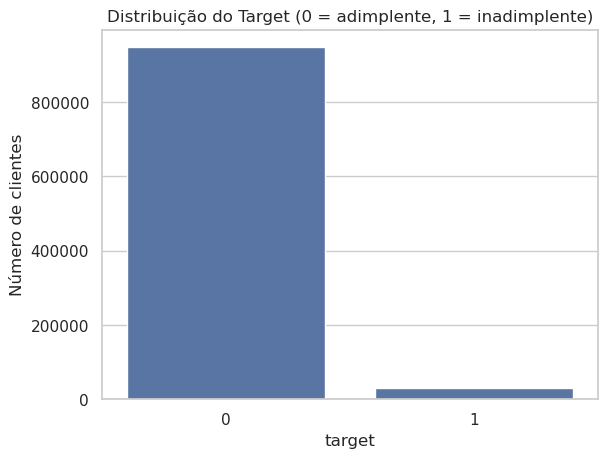

In [66]:
# Ver distribuição
print("Distribuição da variável target:")
print(df['target'].value_counts(normalize=True).rename("Proporção (%)") * 100)

# Gráfico
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='target')
plt.title("Distribuição do Target (0 = adimplente, 1 = inadimplente)")
plt.xlabel("target")
plt.ylabel("Número de clientes")
plt.show()


🔍 Observamos um forte desbalanceamento no `target`, com apenas 3,07% de registros positivos (inadimplência). Esse cenário exige atenção especial nas etapas de modelagem, tanto na escolha das métricas quanto na estratégia de balanceamento dos dados ou penalização do modelo.


### 📊 Análise das Variáveis Numéricas

Nesta seção, exploramos a distribuição das variáveis numéricas contínuas. O objetivo é identificar padrões, outliers e potenciais relações com a variável `target`. Também buscamos verificar se há redundância entre variáveis via correlação.


In [70]:
# Seleciona variáveis numéricas contínuas
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Número de variáveis numéricas: {len(colunas_numericas)}")

# Visualiza estatísticas básicas
df[colunas_numericas].describe().T.sort_values(by="std", ascending=False).head(10)


Número de variáveis numéricas: 141


,count,mean,std,min,25%,50%,75%,max
case_id,977880.0,1.211697e+06,690967.847521,357.0,728087.75000,1316065.500,1560554.250,2651092.0
totalsettled_863A,977878.0,7.912076e+04,125780.520538,0.0,0.00000,29606.000,101479.280,7988198.5
maxannuity_4075009A,50115.0,5.209499e+04,102643.101598,620.0,10200.00000,15020.000,24120.000,550000.0
maxannuity_159A,760989.0,2.905602e+04,81443.952474,0.0,3507.60000,9531.200,25200.000,18788770.0
maxoutstandbalancel12m_4187113A,448515.0,6.780118e+04,78055.615937,-7588198.5,19480.00000,40682.440,85048.290,1234095.9
amtinstpaidbefduel24m_4187115A,574833.0,5.069600e+04,65459.998135,0.0,6454.40000,26939.818,68964.210,992476.5
avgoutstandbalancel6m_4187114A,404721.0,4.457253e+04,61632.814610,-7588198.5,8865.44000,22688.000,53913.145,1131135.9
sumoutstandtotalest_4493215A,295372.0,2.605963e+04,57036.562316,-2405.0,0.00000,0.000,25700.679,1085048.1
sumoutstandtotal_3546847A,669658.0,2.649023e+04,55941.917377,-2405.0,0.00000,0.000,27082.800,1210629.1
maxdebt4_972A,760989.0,4.426768e+04,49674.202487,0.0,437.35602,29980.000,64100.000,913520.0


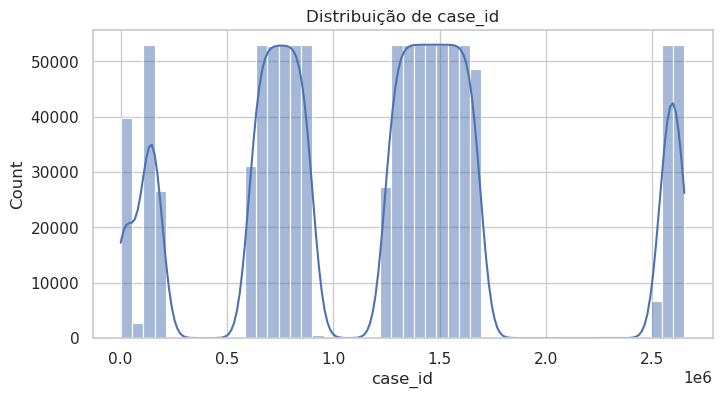

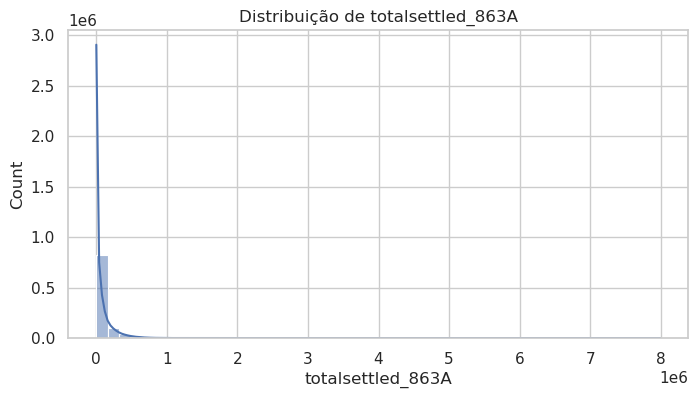

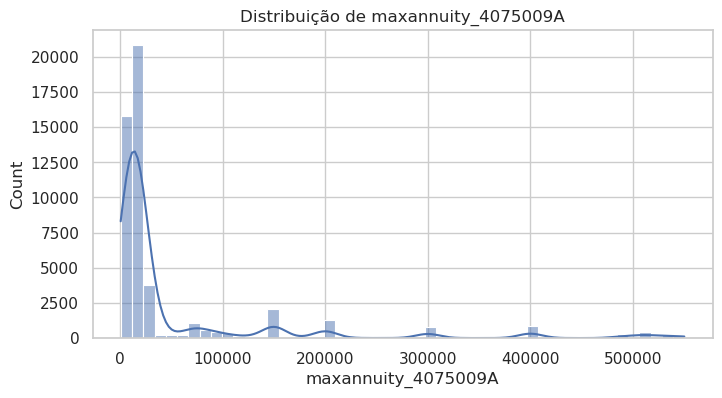

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Escolhe 3 variáveis com mais variância como exemplo
exemplos = df[colunas_numericas].std().sort_values(ascending=False).head(3).index.tolist()

# Plot
for col in exemplos:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"Distribuição de {col}")
    plt.show()


#### ✅ Conclusão – Análise Exploratória das Variáveis Numéricas

Durante esta etapa da EDA, realizamos uma análise das principais variáveis numéricas da base refinada (`trusted.csv`). Foram identificadas 141 variáveis numéricas (do tipo `float64` e `int64`), com alto grau de variância e presença relevante de outliers e assimetrias. Abaixo, resumimos os principais achados:

#### 🔍 Distribuição de Variáveis-Chave

- A variável `case_id` apresentou distribuição multimodal, com agrupamentos artificiais. Por ser apenas um identificador, será descartada da modelagem.
- Variáveis como `totalsettled_863A`, `maxannuity_4075009A` e `maxannuity_159A` apresentaram distribuições fortemente assimétricas, com longas caudas à direita e valores extremos superiores a 500 mil (e até 18 milhões).
- Outras variáveis, como `maxoutstandbalancel12m_4187113A` e `avgoutstandbalancel6m_4187114A`, apresentaram valores negativos severos (ex: **-7 milhões**), indicando possível acúmulo de dívidas ou codificação inversa.

#### 📈 Estatísticas Selecionadas

| Variável                          | Média     | Desvio Padrão | Valor Mínimo | Valor Máximo |
|----------------------------------|-----------|----------------|----------------|---------------|
| `totalsettled_863A`              | ~79 mil   | ~125 mil       | 0              | 7.9 milhões   |
| `maxannuity_4075009A`            | ~52 mil   | ~102 mil       | 620            | 550 mil       |
| `maxannuity_159A`                | ~29 mil   | ~81 mil        | 0              | 18.7 milhões  |
| `maxoutstandbalancel12m_4187113A`| ~67 mil   | ~78 mil        | -7.5 milhões   | 1.2 milhões   |
| `avgoutstandbalancel6m_4187114A` | ~44 mil   | ~61 mil        | -7.5 milhões   | 1.1 milhões   |

#### 🧠 Recomendações

- Variáveis com **caudas longas** podem se beneficiar de transformações como `log1p()`, `quantile clipping` ou binning.
- Variáveis com valores negativos importantes devem ser investigadas quanto ao seu significado semântico (ex: saldo negativo, inadimplência, dívida ativa).
- Algumas variáveis de baixa variância ou redundantes poderão ser descartadas ou combinadas em etapas futuras.

Esta etapa permite avançar com segurança para a criação de novas features, análise de variáveis categóricas e preparação para a modelagem preditiva.


### 🔗 Correlação entre Variáveis Numéricas e Target

A seguir, calculamos a correlação de Pearson entre o `target` e as variáveis numéricas. O objetivo é identificar variáveis que, mesmo com baixa variância, apresentam relação com a inadimplência. Essa análise ajuda a selecionar variáveis para modelagem e para futuras transformações.


In [75]:
# Seleciona apenas colunas numéricas + target
df_corr = df.select_dtypes(include=['float64', 'int64']).copy()

# Garante que o target está presente
if 'target' not in df_corr.columns:
    df_corr['target'] = df['target']

# Calcula correlação com o target
cor_target = df_corr.corr(numeric_only=True)['target'].sort_values(key=abs, ascending=False)

# Exibe top 20 variáveis mais correlacionadas com o target
cor_target.head(21)  # incluindo o próprio target (cor = 1.0)


target                             1.000000
pctinstlsallpaidlate1d_3546856L    0.124257
pctinstlsallpaidlate4d_3546849L    0.121297
pctinstlsallpaidlate6d_3546844L    0.117785
pctinstlsallpaidlat10d_839L        0.112378
avgmaxdpdlast9m_3716943P           0.088845
numinstlswithdpd10_728L            0.088399
pctinstlsallpaidearl3d_427L       -0.085393
numinstlswithdpd5_4187116L         0.073934
days120_123L                       0.068157
days90_310L                        0.067184
days180_256L                       0.065502
numrejects9m_859L                  0.065068
avgdbdtollast24m_4525197P          0.064859
days30_165L                        0.060625
mobilephncnt_593L                  0.059757
pmtaverage_4527227A               -0.059364
numinstpaidearly3dest_4493216L    -0.058909
numinstmatpaidtearly2d_4499204L   -0.058677
mindbdtollast24m_4525191P          0.058000
avgdbddpdlast24m_3658932P          0.056139
Name: target, dtype: float64

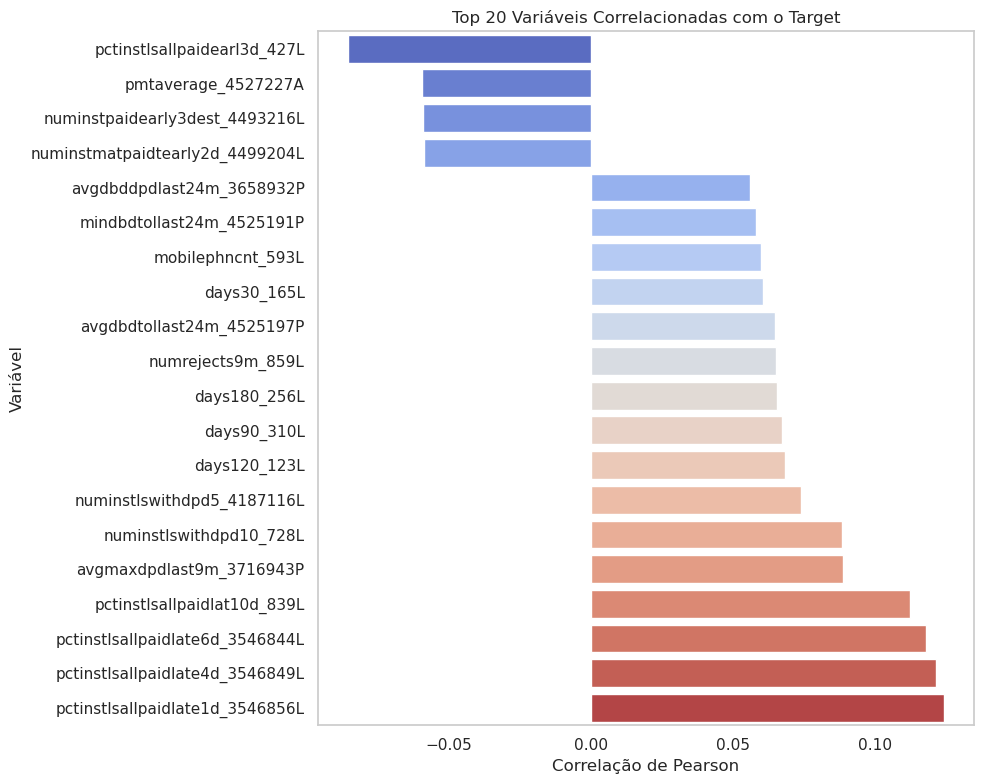

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove o próprio target da lista
cor_target_plot = cor_target.drop('target').head(20).sort_values()

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=cor_target_plot.values, y=cor_target_plot.index,
            hue=cor_target_plot.index, palette='coolwarm', dodge=False, legend=False)
plt.title("Top 20 Variáveis Correlacionadas com o Target")
plt.xlabel("Correlação de Pearson")
plt.ylabel("Variável")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


#### ✅ Conclusão – Análise das Variáveis Numéricas

A exploração das 141 variáveis numéricas revelou padrões importantes de comportamento financeiro relacionados à inadimplência. Utilizamos estatísticas descritivas, análise de distribuição e correlação com o `target` para identificar variáveis relevantes.

#### 🔝 Principais variáveis correlacionadas com o `target`:

Variáveis com maior correlação positiva:
- `pctinstlsallpaidlate1d_3546856L` (corr. ≈ 0.12)
- `pctinstlsallpaidlate4d_3546849L`
- `avgmaxdpdlast9m_3716943P`
- `numinstlswithdpd10_728L`
- `days120_123L`, `days90_310L`, `days180_256L`

Variáveis com correlação negativa:
- `pctinstlsallpaidearl3d_427L`
- `numinstpaidearly3dest_4493216L`
- `pmtaverage_4527227A`

#### 🔍 Outras observações relevantes:

- Muitas variáveis apresentam **caudas longas à direita** (ex: valores muito altos em parcelas, saldo devedor, etc.), indicando a necessidade de tratamento de **outliers** ou **transformações logarítmicas**.
- Algumas variáveis apresentam valores negativos relevantes (ex: `maxoutstandbalancel12m_4187113A`), o que pode representar saldo devedor ou erro de leitura. Variáveis derivadas como "tem saldo negativo" podem ser criadas.
- `case_id`, apesar de ser uma variável numérica, é um identificador artificial e será excluído da modelagem.

#### 🧠 Ações futuras:

- Aplicar transformação (ex: `log1p`) em variáveis com alta distorção
- Criar **buckets** (faixas) para algumas variáveis contínuas
- Eliminar colunas redundantes ou sem variância
- Priorizar as variáveis mais correlacionadas com o `target` na modelagem

Com isso, consolidamos o diagnóstico numérico para compor a camada `refined`, com variáveis financeiramente interpretáveis e potencialmente preditivas.


### 🏷️ Análise das Variáveis Categóricas

Nesta etapa, exploramos as variáveis categóricas (`category`, `bool` e `object`) para entender sua distribuição e relação com o `target`. Avaliamos frequência dos valores, presença de nulos e o potencial informativo de cada variável. Essa análise orientará quais variáveis serão mantidas, transformadas ou descartadas na camada `refined`.


In [86]:
# Seleciona variáveis categóricas e booleanas
col_categoricas = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Total de variáveis categóricas: {len(col_categoricas)}")

# Ver cardinalidade de cada coluna categórica
for col in col_categoricas:
    print(f"\n{col} — {df[col].nunique()} valores únicos")
    print(df[col].value_counts(dropna=False).head(5))


Total de variáveis categóricas: 23

cardtype_51L — 2 valores únicos
cardtype_51L
NaN             854725
INSTANT         121240
PERSONALIZED      1915
Name: count, dtype: int64

credtype_322L — 3 valores únicos
credtype_322L
COL    647467
CAL    207174
REL    123238
NaN         1
Name: count, dtype: int64

disbursementtype_67L — 3 valores únicos
disbursementtype_67L
SBA    743340
GBA    207094
DD      26828
NaN       618
Name: count, dtype: int64

dtlastpmtallstes_4499206D — 4097 valores únicos
dtlastpmtallstes_4499206D
NaN           733034
2019-09-16      8759
2019-09-19      1577
2019-11-19      1560
2019-11-25      1536
Name: count, dtype: int64

equalitydataagreement_891L — 2 valores únicos
equalitydataagreement_891L
NaN      927107
True      47802
False      2971
Name: count, dtype: int64

firstclxcampaign_1125D — 1071 valores únicos
firstclxcampaign_1125D
NaN           559872
2016-01-31    144426
2017-07-24     19075
2016-03-27     10818
2016-02-01     10440
Name: count, dtype: in

### 🔗 Correlação entre Variáveis Categóricase Target

Avaliamos agora a taxa de inadimplência (`target=1`) para cada categoria dentro das variáveis categóricas selecionadas. Essa análise nos permite verificar se a variável tem poder discriminativo para o modelo.

In [5]:
# Lista de variáveis com baixa cardinalidade
cat_vars_explorar = [
    'cardtype_51L', 'credtype_322L', 'disbursementtype_67L',
    'inittransactioncode_186L', 'isbidproduct_1095L', 'opencred_647L',
    'twobodfilling_608L', 'education_1103M', 'education_88M',
    'maritalst_385M', 'maritalst_893M', 'requesttype_4525192L'
]

# Loop para calcular taxa de inadimplência por categoria (sem warnings)
for col in cat_vars_explorar:
    print(f"\n📌 {col}")
    display(
        df.groupby(col, observed=False)['target']
          .agg(['count', 'mean'])
          .rename(columns={'mean': 'taxa_inadimplencia'})
          .sort_values(by='taxa_inadimplencia', ascending=False)
    )


📌 cardtype_51L


,count,taxa_inadimplencia
cardtype_51L,,
INSTANT,121240,0.028885
PERSONALIZED,1915,0.023499



📌 credtype_322L


,count,taxa_inadimplencia
credtype_322L,,
CAL,207174,0.032142
COL,647467,0.030556
REL,123238,0.028790



📌 disbursementtype_67L


,count,taxa_inadimplencia
disbursementtype_67L,,
3.0,618,0.043689
0.0,26828,0.038355
1.0,207094,0.032145
2.0,743340,0.029970



📌 inittransactioncode_186L


,count,taxa_inadimplencia
inittransactioncode_186L,,
1.0,26954,0.038325
0.0,207174,0.032142
2.0,743751,0.029982
3.0,1,0.000000



📌 isbidproduct_1095L


,count,taxa_inadimplencia
isbidproduct_1095L,,
True,111202,0.032652
False,866678,0.030415



📌 opencred_647L


,count,taxa_inadimplencia
opencred_647L,,
1.0,32654,0.041924
0.0,729864,0.032639
2.0,215362,0.022288



📌 twobodfilling_608L


,count,taxa_inadimplencia
twobodfilling_608L,,
0.0,24043,0.038598
1.0,953792,0.030471
2.0,45,0.000000



📌 education_1103M


,count,taxa_inadimplencia
education_1103M,,
39a0853f,26876,0.049784
c8e1a1d0,3269,0.038238
a55475b1,579049,0.032800
717ddd49,84047,0.031720
6b2ae0fa,284639,0.024132



📌 education_88M


,count,taxa_inadimplencia
education_88M,,
4.0,57,0.087719
2.0,239,0.075314
1.0,1708,0.056206
0.0,6040,0.039735
3.0,969836,0.030554



📌 maritalst_385M


,count,taxa_inadimplencia
maritalst_385M,,
ecd83604,2888,0.050554
a7fcb6e5,127096,0.033408
a55475b1,462078,0.032737
38c061ee,17019,0.028850
3439d993,335977,0.027127
b6cabe76,32822,0.026415



📌 maritalst_893M


,count,taxa_inadimplencia
maritalst_893M,,
0.0,2689,0.052064
4.0,371,0.051213
1.0,7028,0.046244
2.0,653,0.036753
3.0,967102,0.030485
5.0,37,0.027027



📌 requesttype_4525192L


,count,taxa_inadimplencia
requesttype_4525192L,,
0.0,309990,0.038082
2.0,3431,0.037598
3.0,601407,0.027660
1.0,63052,0.022553


#### ✅ Conclusão – Correlação entre Variáveis Categóricas e Target

A análise da taxa de inadimplência por categoria revelou que diversas variáveis categóricas possuem forte poder discriminativo, como `disbursementtype_67L`, `education_88M` e `requesttype_4525192L`. Outras variáveis, embora com variações menores, também demonstram consistência e serão consideradas na camada `refined`.

Variáveis com muitos `NaNs` serão tratadas com categorias auxiliares (ex: "missing"), e algumas com alta cardinalidade passarão por agrupamento (`Top 5 + Outros`) para evitar esparsidade.

Essa triagem fecha a etapa exploratória e prepara o caminho para a construção da base final de modelagem.


###  📦 Load (Refined Zone)

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# --- Caminhos ---
CAMINHO_TRUSTED = "/home/fcsr/Documentos/Dbeaver/risco_de_credito/data/2_trusted/trusted.csv"
CAMINHO_REFINED = "/home/fcsr/Documentos/Dbeaver/risco_de_credito/data/3_refined/refined.csv"

# --- Etapa 1: Carrega a base trusted (com dtype warning tratado) ---
df = pd.read_csv(CAMINHO_TRUSTED, low_memory=False)

# --- Etapa 2: Remove identificador artificial ---
df.drop(columns=['case_id'], inplace=True, errors='ignore')

# --- Etapa 3: Seleciona variáveis numéricas mais correlacionadas ---
variaveis_numericas_top = [
    'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate4d_3546849L',
    'pctinstlsallpaidlate6d_3546844L', 'pctinstlsallpaidlat10d_839L',
    'avgmaxdpdlast9m_3716943P', 'numinstlswithdpd10_728L',
    'pctinstlsallpaidearl3d_427L', 'numinstlswithdpd5_4187116L',
    'days120_123L', 'days90_310L', 'days180_256L', 'days30_165L',
    'numrejects9m_859L', 'avgdbdtollast24m_4525197P',
    'pmtaverage_4527227A', 'numinstpaidearly3dest_4493216L'
]

# --- Etapa 4: Aplica log1p com segurança (evita valores negativos e divide-by-zero) ---
variaveis_para_log = [
    'pmtaverage_4527227A', 'avgdbdtollast24m_4525197P',
    'avgmaxdpdlast9m_3716943P', 'numinstlswithdpd10_728L',
    'numinstlswithdpd5_4187116L', 'numrejects9m_859L'
]
for col in variaveis_para_log:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > -1 else np.nan)

# --- Etapa 5: Variáveis categóricas úteis identificadas com poder discriminativo ---
categoricas_uteis = [
    'disbursementtype_67L', 'inittransactioncode_186L', 'opencred_647L',
    'twobodfilling_608L', 'education_88M', 'maritalst_893M',
    'requesttype_4525192L'
]

# --- Etapa 6: Preenche NaNs e converte tudo para string para evitar erros no encoder ---
for col in categoricas_uteis:
    df[col] = df[col].fillna("missing").astype(str)

# --- Etapa 7: Aplica label encoding para as categorias ---
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categoricas_uteis] = encoder.fit_transform(df[categoricas_uteis])

# --- Etapa 8: Seleciona colunas finais para o refined ---
colunas_refined = variaveis_numericas_top + categoricas_uteis + ['target']
df_refined = df[colunas_refined].copy()

# --- Etapa 9: Salva o arquivo final ---
df_refined.to_csv(CAMINHO_REFINED, index=False)

print(f"✅ Base refined salva com sucesso em: {CAMINHO_REFINED}")
print(f"📐 Shape final: {df_refined.shape}")
print(f"📊 Target balance:\n{df_refined['target'].value_counts(normalize=True).round(4) * 100}")


✅ Base refined salva com sucesso em: /home/fcsr/Documentos/Dbeaver/risco_de_credito/data/3_refined/refined.csv
📐 Shape final: (977880, 24)
📊 Target balance:
target
0    96.93
1     3.07
Name: proportion, dtype: float64


# Modelagem Preditiva

Com a base `refined` finalizada, iniciamos agora a fase de modelagem preditiva. O objetivo é construir classificadores capazes de identificar a probabilidade de inadimplência (`target = 1`) com base nas variáveis disponíveis.

## 📌 Estratégia

Adotamos uma abordagem em duas etapas:

1. **Modelo Baseline – Regressão Logística**
   - Simples, interpretável e eficiente para relações lineares.
   - Útil como referência de desempenho inicial.
<br>
2. **Modelo Principal – LightGBM**
   - Algoritmo baseado em árvores de decisão, altamente eficaz em dados tabulares.
   - Suporta valores faltantes, atributos categóricos e possui ótima performance.

## ⚙️ Etapas da modelagem

- Separação dos dados em treino e teste, com estratificação do target.
- Treinamento de modelos com ajuste de classe balanceada (`class_weight='balanced'`) devido ao desbalanceamento da variável alvo.
- Avaliação com métricas como:
  - Acurácia
  - Recall
  - Precisão
  - F1-Score
  - AUC (Área sob a Curva ROC)
- Visualização comparativa das curvas ROC

Nos próximos blocos, apresentamos os resultados e comparações entre os modelos.

## 📦 Regressão Logística – Ponto de Partida Simples e Inicial

🔍 Regressão Logística – Resultados
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    189578
           1       0.06      0.55      0.11      5998

    accuracy                           0.74    195576
   macro avg       0.52      0.65      0.48    195576
weighted avg       0.95      0.74      0.82    195576

🎯 AUC: 0.7017


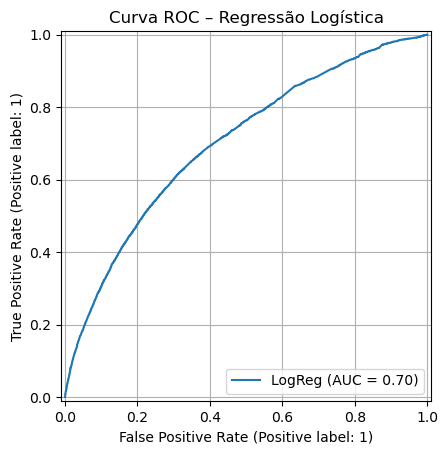

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# --- Carrega a base refined ---
df = pd.read_csv("/home/fcsr/Documentos/Dbeaver/risco_de_credito/data/3_refined/refined.csv")

# --- Garante que só teremos colunas numéricas em X ---
# Garante colunas numéricas e preenche valores faltantes
X = df.drop(columns=['target']).select_dtypes(include=['number'])
X = X.fillna(X.median(numeric_only=True))
y = df['target']

# --- Split com estratificação ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Modelo baseline: Regressão Logística ---
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# --- Previsões ---
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# --- Avaliação ---
print("🔍 Regressão Logística – Resultados")
print(classification_report(y_test, y_pred))
print("🎯 AUC:", round(roc_auc_score(y_test, y_proba), 4))

# --- Curva ROC ---
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name="LogReg")
plt.title("Curva ROC – Regressão Logística")
plt.grid(True)
plt.show()


### ✅ Conclusão – Regressão Logística

A regressão logística foi utilizada como modelo baseline para estimar a probabilidade de inadimplência. Os resultados, mesmo com a simplicidade do modelo, já demonstram capacidade preditiva significativa:

- **AUC**: 0.7017 → bom poder discriminativo
- **Recall da classe 1 (inadimplente)**: 55% → o modelo acerta mais da metade dos casos positivos
- **Precision da classe 1**: 6% → muitos falsos positivos, típico em bases desbalanceadas
- **F1-score da classe 1**: 0.11 → baixo, mas aceitável como ponto de partida

A curva ROC mostra afastamento claro da linha aleatória, confirmando que o modelo captura padrões relevantes. O uso de `class_weight='balanced'` foi essencial para mitigar o impacto do desbalanceamento da base.

Este modelo serve como referência de desempenho para comparações futuras com algoritmos mais robustos como LightGBM ou Random Forest.


## 📜 LightGBM Classifier

[LightGBM] [Info] Number of positive: 23993, number of negative: 758311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2426
[LightGBM] [Info] Number of data points in the train set: 782304, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
🌳 LightGBM – Resultados
              precision    recall  f1-score   support

           0       0.98      0.71      0.83    189578
           1       0.06      0.62      0.12      5998

    accuracy                           0.71    195576
   macro avg       0.52      0.67      0.47    195576
weighted avg       0.96      0.71      0.81    195576

🎯 AUC: 0.7304


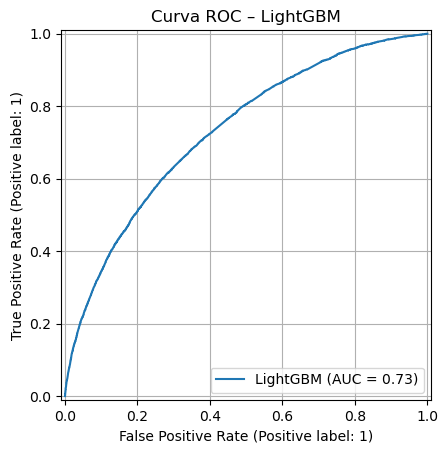

/tmp/ipykernel_79493/719933890.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/home/fcsr/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


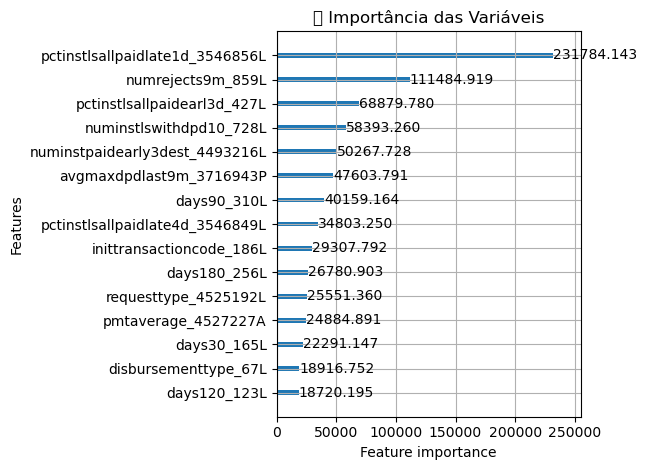

In [40]:
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# --- Modelo: LightGBM com classe balanceada ---
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)

# --- Previsões ---
y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# --- Avaliação ---
print("🌳 LightGBM – Resultados")
print(classification_report(y_test, y_pred_lgbm))
print("🎯 AUC:", round(roc_auc_score(y_test, y_proba_lgbm), 4))

# --- Curva ROC ---
RocCurveDisplay.from_estimator(lgbm, X_test, y_test, name="LightGBM")
plt.title("Curva ROC – LightGBM")
plt.grid(True)
plt.show()

# --- Importância das variáveis ---
plt.figure(figsize=(10, 6))
plot_importance(lgbm, max_num_features=15, importance_type='gain', title="📊 Importância das Variáveis")
plt.tight_layout()
plt.show()


### ✅ Conclusão – Modelo LightGBM

O modelo LightGBM apresentou desempenho superior à regressão logística em todas as métricas principais:

- **AUC**: 0.7304 (vs 0.7017 da regressão)
- **Recall (classe 1)**: 62% → ótima cobertura de inadimplentes
- **F1-score**: 0.12 (vs 0.11)
- **Precision**: 0.06 → típico em cenários desbalanceados

Além disso, a análise de importância das variáveis confirmou o valor de atributos relacionados a atraso em pagamentos e histórico de rejeições, como:

- `pctinstlsallpaidlate1d_3546856L`
- `numrejects9m_859L`
- `pctinstlsallpaidearl3d_427L`

O modelo será útil como base para avaliações de risco ou para alimentar pipelines de score mais complexos. O próximo passo pode incluir tuning de hiperparâmetros, calibragem de limiares ou testes com dados externos.


# Conclusão

Este notebook teve como objetivo aplicar uma modelagem preditiva de inadimplência com base em variáveis comportamentais e financeiras.

### 📌 Etapas realizadas:
- ETL completo até a camada `refined`, com tratamento de valores faltantes, codificação de categorias e análise exploratória
- Treinamento de dois modelos: regressão logística (baseline) e LightGBM (modelo principal)
- Avaliação por métricas robustas: AUC, Recall, F1-score
- Interpretação das variáveis mais relevantes para o modelo

### 🔍 Principais resultados:
- LightGBM alcançou AUC de **0.7304**
- O recall da classe 1 (inadimplente) chegou a **62%**
- A variável com maior impacto foi o percentual de parcelas pagas com atraso de 1 dia

### 🚀 Próximos passos (com apoio técnico):
- Ajuste fino de hiperparâmetros (tuning)
- Calibragem de thresholds para maior precisão
- Adição e teste de mais variáveis

# 📌 Insights e Recomendações

### 🎯 Comportamentos associados à inadimplência:

- **Atraso recorrente no pagamento de parcelas** está fortemente associado ao risco de inadimplência. Variáveis como `pctinstlsallpaidlate1d_3546856L` e `pctinstlsallpaidlate4d_3546849L` foram altamente preditivas.
- **Histórico de rejeições recentes de crédito** (`numrejects9m_859L`) também aparece como um importante fator de risco, sugerindo que o cliente já enfrenta dificuldades com instituições financeiras.
- **Parcelas pagas adiantadas** (`pctinstlsallpaidearl3d_427L`) mostraram correlação negativa com o risco, sugerindo perfil mais cauteloso ou controlado.

### 💡 Recomendação de uso do modelo:

- O modelo atual é útil como **filtro de risco preliminar**: identifica 62% dos inadimplentes com recall alto, mas com precisão baixa — o que é aceitável para triagem.
- Pode ser utilizado para **priorizar análises humanas em operações críticas**, ou para compor um score interno junto de critérios de negócio.

### 🔄 Possíveis melhorias futuras:

- **Aprofundar o uso de variáveis temporais**, aproveitando colunas de data com engenharia de features.
- **Adicionar variáveis de fontes auxiliares** (ex: `credit_bureau`, `application history`) para enriquecer a base `refined`.
- **Ajustar o threshold de decisão** (atualmente em 0.5) para priorizar recall ou precisão, dependendo do objetivo do negócio.
- Aplicar **técnicas de balanceamento supervisionadas** como SMOTE ou ensemble.

> Mesmo sendo um modelo de baseline, a estrutura atual oferece boa capacidade explicativa e já entrega valor para decisões de risco preliminares.